In [2]:
from pyNBA.Data.data import QueryData
from pyNBA.Models.helpers import CleanData

from pyNBA.Data.constants import ROTO_NAME_TO_NBA_NAME, DB_TEAM_TO_NBA_TEAM

# for models
from pyNBA.DFS.rules import FPCalculator
from pyNBA.DFS.constants import Site

# for backtesting
from pydfs_lineup_optimizer import get_optimizer, Sport
from pydfs_lineup_optimizer import Player

from pyNBA.Models.fantasy_points import FPModel
from pyNBA.Models.variance import VarianceModel

from collections import Counter
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()

# misc
import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [3]:
query_data = QueryData()
clean_data = CleanData()

# historical player boxscore data
boxscores = query_data.query_boxscore_data()

# we are only interested in the boxscores of healthy and non-resting players
boxscores = clean_data.drop_rows_player_injured(boxscores)
boxscores = clean_data.drop_rows_player_rest(boxscores)

# historical quarterly boxscore data
quarterly_boxscore_data = query_data.query_quarterly_boxscore_data()

# historical vegas odds data
odds_data = query_data.query_odds_data()

# historical DFS salary data
salaries = query_data.query_salary_data()
salaries = salaries.rename(columns={"POSITION": "DFS_POSITION"})

# historical DFS contest data
contests = query_data.query_contest_data()
contests = contests.loc[contests['CASHLINE'] > 0].dropna(subset=['CASHLINE'])

/Users/brandonshimiaie/Projects/pyNBA/sqlite/db/nba.db
2.6.0


In [4]:
def name_converter(name):
    name_list = name.split(',')
    name = "{} {}".format(name_list[-1].lstrip(), ' '.join(name_list[:-1]))
    if name in ROTO_NAME_TO_NBA_NAME:
        return ROTO_NAME_TO_NBA_NAME[name]
    return name

In [5]:
salaries['NAME'] = salaries['PLAYER'].apply(name_converter)
boxscores = boxscores.merge(
    salaries, how='left', on=['DATE', 'NAME']
)
boxscores['REB'] = boxscores['DREB'] + boxscores['OREB']

# to calculate fantasy points
DKFPCalculator = FPCalculator(Site.DRAFTKINGS)

# isolate Draftkings salaries
dk_boxscores = boxscores.loc[boxscores['SITE'] == Site.DRAFTKINGS]

optimizer = get_optimizer(Site.DRAFTKINGS, Sport.BASKETBALL)

In [6]:
train_seasons = dk_boxscores.loc[dk_boxscores['SEASON'].isin(['2014-15', '2015-16', '2016-17', '2018-19'])]
test_season = dk_boxscores.loc[dk_boxscores['SEASON'] == '2019-20']

# actual fantasy points
test_season['DKFP'] = test_season.apply(
    lambda x: DKFPCalculator.calculate_fantasy_points(
        x['SEASON'], x['PTS'], x['REB'], x['AST'], x['TOV'], x['BLK'], x['STL'], x['FG3M']
    ), 
    axis=1
)

# project fantasy points
fp_model = FPModel(train_seasons, test_season, Site.DRAFTKINGS)
fp_model.train_model(quarterly_boxscore_data, odds_data)
predictions, prediction_column = fp_model.predict()
predictions = predictions.dropna(subset=[prediction_column])

# variance
variance_model = VarianceModel(predictions)
predictions, variance_column = variance_model.predict('DKFP', prediction_column)
pct_variance_column = 'RESIDUAL_PCT'
predictions[pct_variance_column] = predictions[variance_column]/predictions[prediction_column]

[('Tyler Herro', 8), ('Domantas Sabonis', 7), ('Andrew Wiggins', 6), ('Kemba Walker', 5), ('Nikola Jokic', 4), ('Evan Fournier', 4), ('Marquese Chriss', 4), ('Marcus Smart', 4), ('Pascal Siakam', 4), ('Trae Young', 3), ('Jeremy Lamb', 3), ('Reggie Jackson', 3), ('Jimmy Butler', 2), ('Kyle Lowry', 2), ('Nikola Vucevic', 2), ('Myles Turner', 2), ('Jae Crowder', 2), ('Coby White', 1), ('Patty Mills', 1), ('Draymond Green', 1), ('Derrick Rose', 1), ('Sekou Doumbouya', 1), ('Bobby Portis', 1), ('Ben McLemore', 1), ('Dillon Brooks', 1), ('OG Anunoby', 1), ('Christian Wood', 1), ('Nerlens Noel', 1), ('Gordon Hayward', 1), ('Harrison Barnes', 1), ('Rudy Gay', 1), ('Doug McDermott', 1)]
32
236


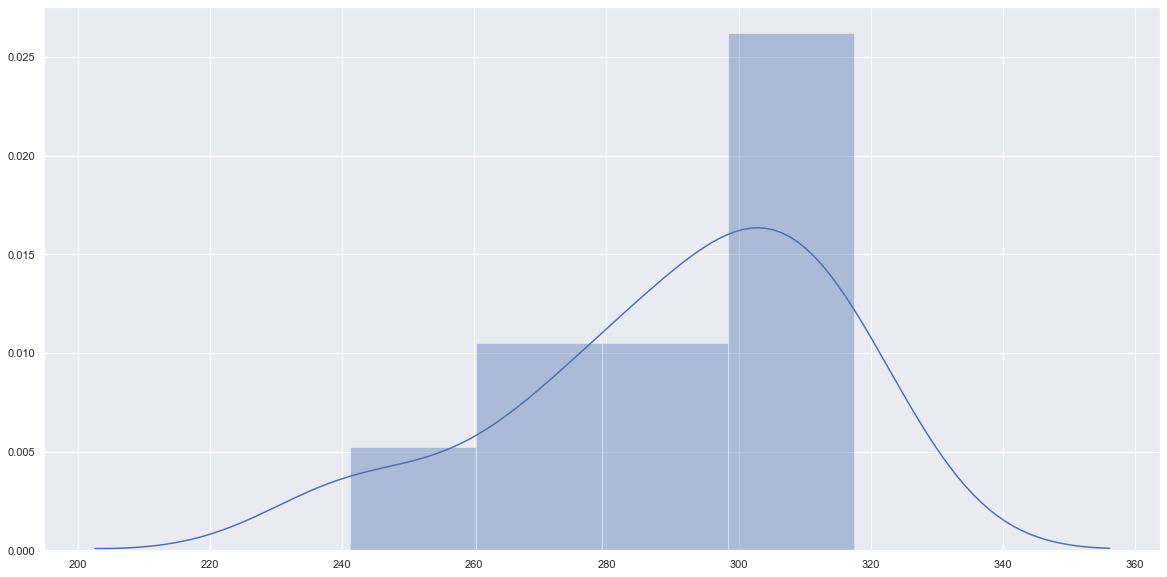

290.8 317.5
CPU times: user 563 ms, sys: 93.7 ms, total: 657 ms
Wall time: 1.14 s


In [8]:
%%time

from numpy.random import normal

test = predictions.loc[predictions['DATE'] == '2020-01-24']
test[pct_variance_column] = test[pct_variance_column].fillna(0.25)
test[pct_variance_column] = test[pct_variance_column].clip(lower=0.10)

players = []
for player_id, player in test.groupby(['PLAYERID']):
    player = player.iloc[0]
    name = player['NAME'].split()
    first_name = name[0]
    last_name = name[1] if len(name) > 1 else ''
    mu = player[prediction_column]
    sigma = player[pct_variance_column]
    salary =  player['SALARY']
    if (mu * (1+ normal(0, sigma)))/salary > 0.005 or mu/salary > 0.005:
        try:
            player = Player(
                player_id, first_name, last_name, player['DFS_POSITION'].split('_'),
                player['TEAM'], salary, mu, standard_deviation=sigma/3
            )
            players.append(player)
        except:
            continue
optimizer.load_players(players)
optimizer.set_min_salary_cap(49500)
lineups = optimizer.optimize(n=10, randomness=True)

c = Counter()
scores = []
for l in lineups:
    player_ids = [i.id for i in l.lineup]
    score = test.loc[test['PLAYERID'].isin(player_ids), 'DKFP'].sum()
    scores.append(score)
    for i in l.lineup:
        c[i.full_name] += 1

print(c.most_common())
print(len(c))
print(len(list(test['PLAYERID'].unique())))

fig = plt.figure(1, figsize=(20, 10))
sns.distplot(scores)
plt.show()
print(np.mean(scores), max(scores))

In [ ]:
print(test.loc[test['NAME'] == 'Damian Lillard', ['NAME', 'DKFP', 'SALARY', prediction_column, pct_variance_column]])
print(test.loc[test['NAME'] == "Anfernee Simons", ['NAME', 'DKFP', 'SALARY', prediction_column, pct_variance_column]])

In [200]:
print(len(list(test['TEAM'].unique())))

20


In [201]:
print(players)

[Montrezl Harrell C (LAC), D'Angelo Russell PG/SG (GSW), Myles Turner C (IND), Bobby Portis PF/C (NYK), Rondae Hollis-Jefferson SF/PF (TOR), Domantas Sabonis PF/C (IND), Marquese Chriss PF/C (GSW), Thon Maker PF/C (DET), Dejounte Murray PG (SAS), Cheick Diallo C (PHX), Pascal Siakam PF/C (TOR), Damion Lee SG (GSW), Bryn Forbes PG/SG (SAS), Derrick Jones SF/PF (MIA), OG Anunoby SF/PF (TOR), Bam Adebayo C (MIA), Derrick White PG/SG (SAS), Josh Hart SG/SF (NOP), PJ Dozier SG/SF (DEN), Dillon Brooks SG (MEM), Monte Morris PG (DEN), Daniel Theis C (BOS), Grayson Allen PG/SG (MEM), Mikal Bridges SG/SF (PHX), Hamidou Diallo SG/SF (OKC), Bruno Fernando C (ATL), Kevin Knox SF/PF (NYK), Josh Okogie SG/SF (MIN), Deandre Ayton PF/C (PHX), Carsen Edwards PG (BOS), Duncan Robinson SG/SF (MIA), De'Andre Hunter SF/PF (ATL), Coby White PG/SG (CHI), Jarrett Culver PG/SG (MIN), Brandon Clarke PF/C (MEM), Sekou Doumbouya SF/PF (DET), Tyler Herro SG (MIA), Jordan Poole SG/SF (GSW), Grant Williams SF/PF (BO

In [87]:
predictions['VALUE'] = predictions[prediction_column]/predictions['SALARY']

import pandas as pd
pd.set_option('display.min_rows', 200)

display(predictions[['DATE', 'NAME', 'SALARY', prediction_column, 'VALUE', pct_variance_column, 'DKFP']].sort_values(by='VALUE', ascending=False))

,DATE,NAME,SALARY,DRAFTKINGS_FP_HAT,VALUE,RESIDUAL_PCT,DKFP
7314,2019-12-09,Gordon Hayward,3000.0,38.864320,0.012955,0.310055,27.25
21432,2020-03-09,Sterling Brown,3000.0,31.220126,0.010407,NaN,31.00
16449,2020-02-02,Elie Okobo,3000.0,30.107021,0.010036,NaN,10.25
3238,2019-11-14,Terance Mann,3000.0,29.598517,0.009866,NaN,14.50
17736,2020-02-10,Malik Beasley,4500.0,42.731185,0.009496,NaN,24.00
20264,2020-03-02,Denzel Valentine,3000.0,27.626450,0.009209,NaN,27.50
15470,2020-01-27,Jakob Poeltl,3200.0,29.048421,0.009078,0.224286,40.25
21421,2020-03-09,Thanasis Antetokounmpo,3000.0,26.171230,0.008724,NaN,25.50
20677,2020-03-04,Moritz Wagner,3200.0,27.388412,0.008559,NaN,25.25
20990,2020-03-06,Aron Baynes,3000.0,25.646063,0.008549,0.339655,69.50


In [220]:
from numpy.random import normal
from numpy.random import choice
from random import randint

num_iterations = 10000
num_competitors_list = [1000, 5000, 10000]
std = 100

s1_list = np.array([
    normal(0, std, num_iterations),
    normal(0, std, num_iterations),
    normal(0, std, num_iterations),
    normal(0, std, num_iterations),
    normal(0, std, num_iterations),
    normal(0, std, num_iterations),
    normal(0, std, num_iterations)
]).T
s1_ownership = np.array([0.50, 0.20, 0.10, 0.10, 0.05, 0.03, 0.02])

s2_list = np.array([
    normal(0, std, num_iterations),
    normal(0, std, num_iterations),
    normal(0, std, num_iterations),
    normal(0, std, num_iterations),
    normal(0, std, num_iterations),
    normal(0, std, num_iterations),
    normal(0, std, num_iterations)
]).T
s2_ownership = np.array([0.50, 0.20, 0.10, 0.10, 0.05, 0.03, 0.02])

s3_list = np.array([
    normal(0, std, num_iterations),
    normal(0, std, num_iterations),
    normal(0, std, num_iterations),
    normal(0, std, num_iterations),
    normal(0, std, num_iterations),
    normal(0, std, num_iterations),
    normal(0, std, num_iterations)
]).T
s3_ownership = np.array([0.50, 0.20, 0.10, 0.10, 0.05, 0.03, 0.02])

s4_list = np.array([
    normal(0, std, num_iterations),
    normal(0, std, num_iterations),
    normal(0, std, num_iterations),
    normal(0, std, num_iterations),
    normal(0, std, num_iterations),
    normal(0, std, num_iterations),
    normal(0, std, num_iterations)
]).T
s4_ownership = np.array([0.50, 0.20, 0.10, 0.10, 0.05, 0.03, 0.02])

s5_list = np.array([
    normal(0, std, num_iterations),
    normal(0, std, num_iterations),
    normal(0, std, num_iterations),
    normal(0, std, num_iterations),
    normal(0, std, num_iterations),
    normal(0, std, num_iterations),
    normal(0, std, num_iterations)
]).T
s5_ownership = np.array([0.50, 0.20, 0.10, 0.10, 0.05, 0.03, 0.02])

s6_list = np.array([
    normal(0, std, num_iterations),
    normal(0, std, num_iterations),
    normal(0, std, num_iterations),
    normal(0, std, num_iterations),
    normal(0, std, num_iterations),
    normal(0, std, num_iterations),
    normal(0, std, num_iterations)
]).T
s6_ownership = np.array([0.50, 0.20, 0.10, 0.10, 0.05, 0.03, 0.02])

s7_list = np.array([
    normal(0, std, num_iterations),
    normal(0, std, num_iterations),
    normal(0, std, num_iterations),
    normal(0, std, num_iterations),
    normal(0, std, num_iterations),
    normal(0, std, num_iterations),
    normal(0, std, num_iterations)
]).T
s7_ownership = np.array([0.50, 0.20, 0.10, 0.10, 0.05, 0.03, 0.02])

for i in range(100):
    num_wins = 0
    max_scores = []
    for i in range(num_iterations):
        num_competitors_i = randint(0,2)
        num_competitors = num_competitors_list[num_competitors_i]

        s1 = s1_list[i]
        s2 = s2_list[i]
        s3 = s3_list[i]
        s4 = s4_list[i]
        s5 = s5_list[i]
        s6 = s6_list[i]
        s7 = s7_list[i]

        s1_i, s2_i, s3_i, s4_i, s5_i, s6_i, s7_i = \
            randint(0,6), randint(0,6), randint(0,6), randint(0,6), randint(0,6), randint(0,6), randint(0,6)
        my_score = s1[s1_i] + s2[s2_i] + s3[s3_i] + s4[s4_i] + s5[s5_i] + s6[s6_i] + s7[s7_i]

        s1_picks = choice(s1, num_competitors, p=s1_ownership)
        s2_picks = choice(s2, num_competitors, p=s2_ownership)
        s3_picks = choice(s3, num_competitors, p=s3_ownership)
        s4_picks = choice(s4, num_competitors, p=s4_ownership)
        s5_picks = choice(s5, num_competitors, p=s5_ownership)
        s6_picks = choice(s6, num_competitors, p=s6_ownership)
        s7_picks = choice(s7, num_competitors, p=s7_ownership)
        max_score = max(sum(np.array([s1_picks, s2_picks, s3_picks, s4_picks, s5_picks, s6_picks, s7_picks])))
        max_scores.append(max_score)
        if my_score > max_score:
            num_wins += 1

    print(num_competitors, [s1_i, s2_i, s3_i, s4_i, s5_i, s6_i, s7_i], num_wins, np.mean(max_scores))

1000 [5, 5, 0, 2, 0, 5, 5] 30 721.0876210762974
1000 [6, 1, 5, 0, 3, 0, 0] 25 721.2009221872224
5000 [0, 4, 1, 6, 3, 1, 4] 33 721.1077581013872


KeyboardInterrupt: 

In [212]:
from pyNBA.Data.data import QueryData
from pyNBA.Data.constants import BAD_CONTEST_SUBSTRINGS

query_data = QueryData()
contest_data = query_data.query_contest_data()
contest_data = contest_data.loc[
    (contest_data['CASHLINE'] > 0) & (contest_data['SLATETYPE'] == 'Classic') & (contest_data['CASHLINE'] > 200) &
    (~contest_data['CONTESTNAME'].str.lower().str.contains('|'.join(BAD_CONTEST_SUBSTRINGS)))
].dropna(subset=['CASHLINE'])
contest_data['MAXROI'] = contest_data['TOPPRIZE']/contest_data['ENTRYFEE']
contest_data = contest_data.loc[contest_data['MAXROI'] > 2]

/Users/brandonshimiaie/Projects/pyNBA/sqlite/db/nba.db
2.6.0


,SITE,DATE,SLATEID,SLATETYPE,GAMECOUNT,TEAMS,CONTESTID,CONTESTNAME,PRIZEPOOL,ENTRYFEE,TOPPRIZE,MAXENTRIES,TOTALENTRIES,CASHLINE,TOPSCORE,MAXROI
172,DRAFTKINGS,2020-03-09,5e66d1fa670a492cd5e8cf3f,Classic,3,MIL_TOR_UTA_ATL_DEN_CHA,5e67980ddd839863a48d7fdf,NBA $5.7K Courtside Special [Single Entry],5700.0,1500.0,5700.0,1.0,5,237.25,237.25,3.800000
1092,DRAFTKINGS,2020-02-24,5e5487811886304247f769a5,Classic,2,PHO_UTA_MEM_LAC,5e553a77836de67bba852b93,NBA $14.2K Courtside Special [Single Entry] (N...,14200.0,1500.0,7500.0,1.0,11,238.50,248.50,5.000000
3514,DRAFTKINGS,2020-01-14,5e1f17d46b70af32b5ac7ce2,Classic,2,DAL_LAC_CLE_GSW,5e1f17d9e52ea732b81dfc47,NBA $17K Courtside Special [Single Entry] (Night),17000.0,1500.0,10000.0,1.0,13,230.00,247.00,6.666667
5417,DRAFTKINGS,2019-12-15,5df7c223d1540b5727ad618e,Classic,2,SAC_NYK_DEN_GSW,5df7c2333520505515917bfb,NBA $5.2K Windmill [$2K to 1st] (Night),5200.0,180.0,2000.0,1.0,33,232.25,237.25,11.111111
6131,DRAFTKINGS,2019-12-03,5de7d2716e990771f513aaaf,Classic,2,LAL_LAC_DEN_POR,5de7d3a47f1f0571fdc03937,NBA $14.2K Courtside Special [Single Entry] (N...,14200.0,1500.0,7500.0,1.0,11,219.25,242.50,5.000000
6600,DRAFTKINGS,2019-11-24,5ddb1aac7269951e34badd54,Classic,4,BKN_WAS_LAC_NOP_SAC_NYK_DEN_PHO,5ddc069e908922268a5070c4,NBA $15K All-Star [Single Entry],15000.0,1060.0,6000.0,1.0,16,223.50,245.25,5.660377
6603,DRAFTKINGS,2019-11-24,5ddb1aac7269951e34badd54,Classic,4,BKN_WAS_LAC_NOP_SAC_NYK_DEN_PHO,5ddc069d908922268a506d13,NBA $30K Thunderdome [Must Fill],30000.0,5300.0,20000.0,1.0,7,216.25,217.25,3.773585
8978,DRAFTKINGS,2019-03-31,5ca1d98cfc9b356857700d7a,Classic,2,MEM_GSW_CHA_LAC,5ca1da7acd96d266bf7cd020,NBA $10.9K Windmill [$3K to 1st] (Night),10900.0,180.0,3000.0,2.0,68,216.50,234.50,16.666667
9962,DRAFTKINGS,2019-03-13,5c89c9c5b5ff6b6507c0e9f5,Classic,2,GSW_UTA_PHO_HOU,5c8a1f7e3cbd17138e90354b,NBA $17K Courtside Special [Single Entry] (Night),17000.0,1500.0,10000.0,1.0,13,237.25,243.25,6.666667
10010,DRAFTKINGS,2019-03-13,5c898be13cbd17138e87980a,Classic,6,DET_GSW_ORL_UTA_MEM_WAS_PHO_ATL_BKN_HOU_OKC_MIA,5c89b89ab5ff6b6507bea43f,NBA $60K Thunderdome [Single Entry],60000.0,5300.0,30000.0,1.0,13,237.00,249.25,5.660377


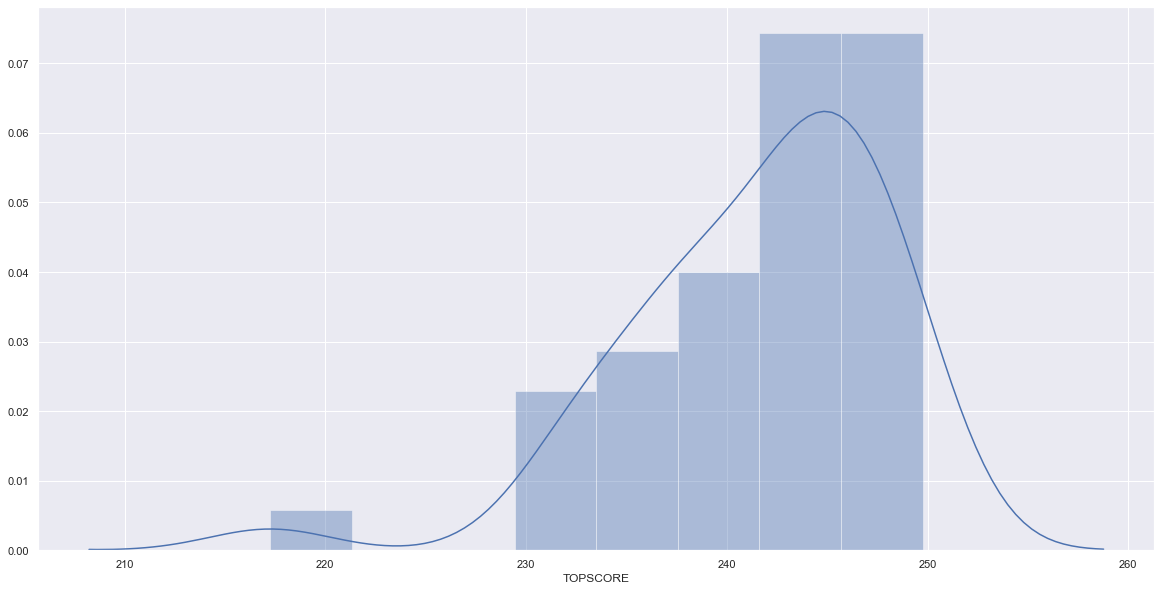

In [325]:
display(contest_data.loc[contest_data['TOPSCORE'] < 250])

fig = plt.figure(1, figsize=(20, 10))
sns.distplot(contest_data.loc[contest_data['TOPSCORE'] < 250, 'TOPSCORE'])
plt.show()

In [399]:
from numpy.random import multivariate_normal

mean = [300, 300]
cov = [
    [30*30, 900],
    [1000, 30*30]
]

a = np.random.multivariate_normal(mean, cov, 1000).T
print(a)

board = a[0]
me = a[1]
print(len([i for i in a[1] if i > max(a[0])]))

[[300.18829303 307.55712563 300.57181544 ... 285.62456629 307.50151072
  291.51772154]
 [307.29156072 279.54270722 308.18823969 ... 277.43403241 258.36658633
  268.18801573]]
6


In [401]:
a = [5, 10, 15, 8, 5]
print(np.sqrt(sum([0.5*i**2 for i in a])))

14.815532390029054


In [496]:
%%time

from numpy.random import normal
from numpy.random import choice

ownerships = [0.20] + ([0.06] * 8) + [float(0.32/291)] * 291

max_scores = []
for i in range(100):
    players = normal(30, 8, 300)
    a = choice(players, (9, 100000), p=ownerships)
    max_score = max(sum(a))
    max_scores.append(max_score)
print(np.mean(max_scores), np.std(max_scores))

# ownerships = [float(1/300)] * 300

# max_scores = []
# for i in range(100):
#     players = normal(30, 8, 300)
#     max_score = max(sum(choice(players, (9, 10000), p=ownerships)))
#     max_scores.append(max_score)
# print(np.mean(max_scores), np.std(max_scores))

369.60112739553733 23.649961385349126
CPU times: user 5.54 s, sys: 159 ms, total: 5.7 s
Wall time: 5.7 s


In [472]:
lineup = choice(list(range(len(players))), (9, 20), p=ownerships, replace=False)
print(lineup)

[[189  13 178  74 144 131 185 271 187 201 138 156 280 255 152 109 264  33
   65 132]
 [  4  66  69 173 211 198  26 270 284 133 195  27  78 145 197 146 190  67
  154 219]
 [ 51 123 129 107 289 248 224  36 191  21  76 171  82 153  64 177 186  98
  136 257]
 [124  40 163 241  95  43 120 119 263 181 217 238  34 273 110 210 125 212
  265   7]
 [249  68 148 240 182 237 170  87  58 234  28   0 283   5 268 221 202  18
  130  38]
 [260 169 209 108 106 215 114 251   3 100  11 161  23  49  84  59 134 172
   90 140]
 [ 53 287  71  70 192 231 155 151  37  35  10   8  46 117  22  56 298 206
  247 253]
 [282 150 167  55  89 291  47 207 281  29  48 122 286  44 104 157 203 275
  116 252]
 [ 15 115  85  62 256 111 243  19 165  30  12  41  60 179 292 213 162  96
  149 208]]


In [475]:
max_scores = []
for i in range(100):
    max_score = -1e9
    for i in range(10000):
        score = sum(choice(players, 9, p=ownerships, replace=False))
        if score > max_score:
            max_score = score
    max_scores.append(max_score)

KeyboardInterrupt: 